## Heat Analysis and Time-Series Prediction  
#### In this notebook, I try to spot the trend of high temperature and make prediction of the temperature. I first visualize the temperature of June, July, August and September from 1979 to 2019.  
#### Then do the seasonal decomposition and make time-series prediction uing Multiple Layer Perceptron(MLP) and Long Short-term Memory networks(LSTM) respectively.  
#### Due to the limitation of data, I choose Germany as the object. 

In [742]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [16]:
df_weather_de = pd.read_csv('weather_german79_19.csv')
df_weather_de.head()

,nation,date,tmax,tmin,precip,month,day,year
0,Germany,1979-01-01,-7.511339,-18.412576,2.408118,1,1,1979
1,Germany,1980-01-01,0.847475,-1.895729,2.819960,1,1,1980
2,Germany,1981-01-01,4.238102,0.252797,7.562355,1,1,1981
3,Germany,1982-01-01,4.052508,2.543797,2.259762,1,1,1982
4,Germany,1983-01-01,1.599186,-2.069932,0.470876,1,1,1983


In [17]:
df_weather_de = df_weather_de.sort_values(by='date')
df_weather_de.set_index('date', inplace=True)

In [19]:
df_weather_de.head()

,nation,tmax,tmin,precip,month,day,year
date,,,,,,,
1979-01-01,Germany,-7.511339,-18.412576,2.408118,1,1,1979
1979-01-02,Germany,-7.644136,-12.931593,1.359078,1,2,1979
1979-01-03,Germany,-5.403746,-12.472797,2.112832,1,3,1979
1979-01-04,Germany,-7.501220,-14.777864,0.766075,1,4,1979
1979-01-05,Germany,-9.710695,-16.087508,0.294268,1,5,1979


In [28]:
df_heat = df_weather_de.loc[df_weather_de['month'].isin([6, 7, 8, 9])]

In [283]:
df_heat['high_t'] = df_heat.apply(lambda x: 1 if x.tmax>=28 else 0, axis=1)
df_heat_year = df_heat.groupby('year').agg({'tmax':['mean', 'max'], 'tmin':['mean', 'max'], 'high_t':'sum'})
df_heat_year.columns = ['_'.join(col) for col in df_heat_year.columns.values]
df_heat_year

/var/folders/0r/06mcd6d15nl01q_rnr4zpvr40000gn/T/ipykernel_15847/3323052030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_heat['high_t'] = df_heat.apply(lambda x: 1 if x.tmax>=28 else 0, axis=1)


,tmax_mean,tmax_max,tmin_mean,tmin_max,high_t_sum
year,,,,,
1979,19.733334,28.522254,10.681674,17.107085,2
1980,19.287462,28.859898,10.934479,17.706407,2
1981,19.747671,29.023508,11.221559,17.289203,3
1982,22.733320,29.889475,12.172932,17.523576,11
1983,22.452981,31.693525,11.793948,18.750864,15
1984,18.572810,30.723797,10.701305,18.388458,4
1985,19.852965,31.538898,10.401995,16.597169,3
1986,19.779767,31.903712,10.150197,18.479525,6
1987,19.040000,29.234932,10.884759,18.671169,1


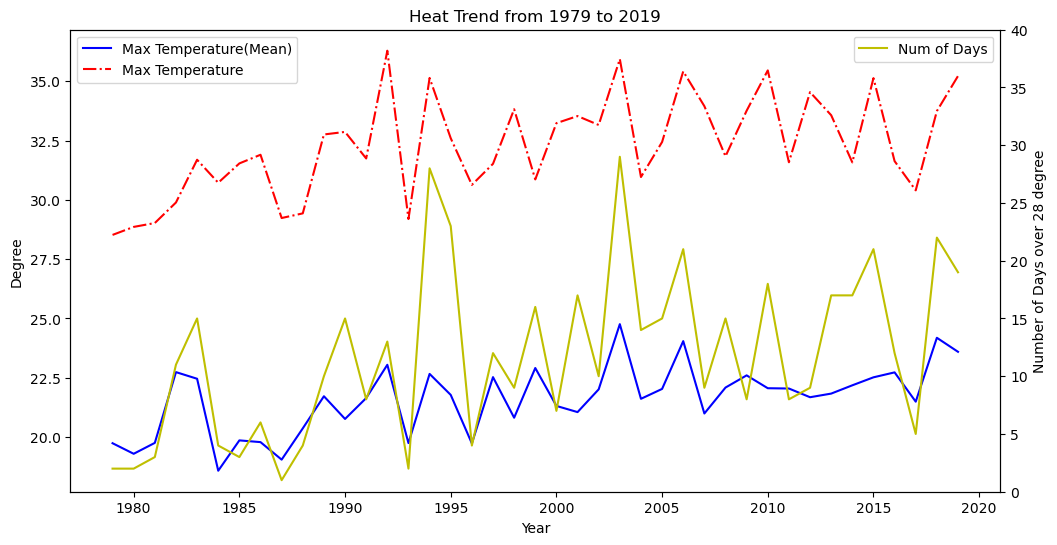

In [780]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.plot(df_heat_year['tmax_mean'], '-b', label='Max Temperature(Mean)')
ax.plot(df_heat_year['tmax_max'], '-.r', label='Max Temperature')

ax2 = ax.twinx()
ax2.plot(df_heat_year['high_t_sum'], '-y', label = 'Num of Days')
ax2.set_ylabel('Number of Days over 28 degree')
ax2.set_ylim(0, 40)
ax.set_xlabel('Year')
ax.set_ylabel('Degree')
ax.legend()
ax.set_title('Heat Trend from 1979 to 2019')
ax2.legend()
plt.savefig('temtrend.png')

In [236]:
from statsmodels.tsa.seasonal import seasonal_decompose

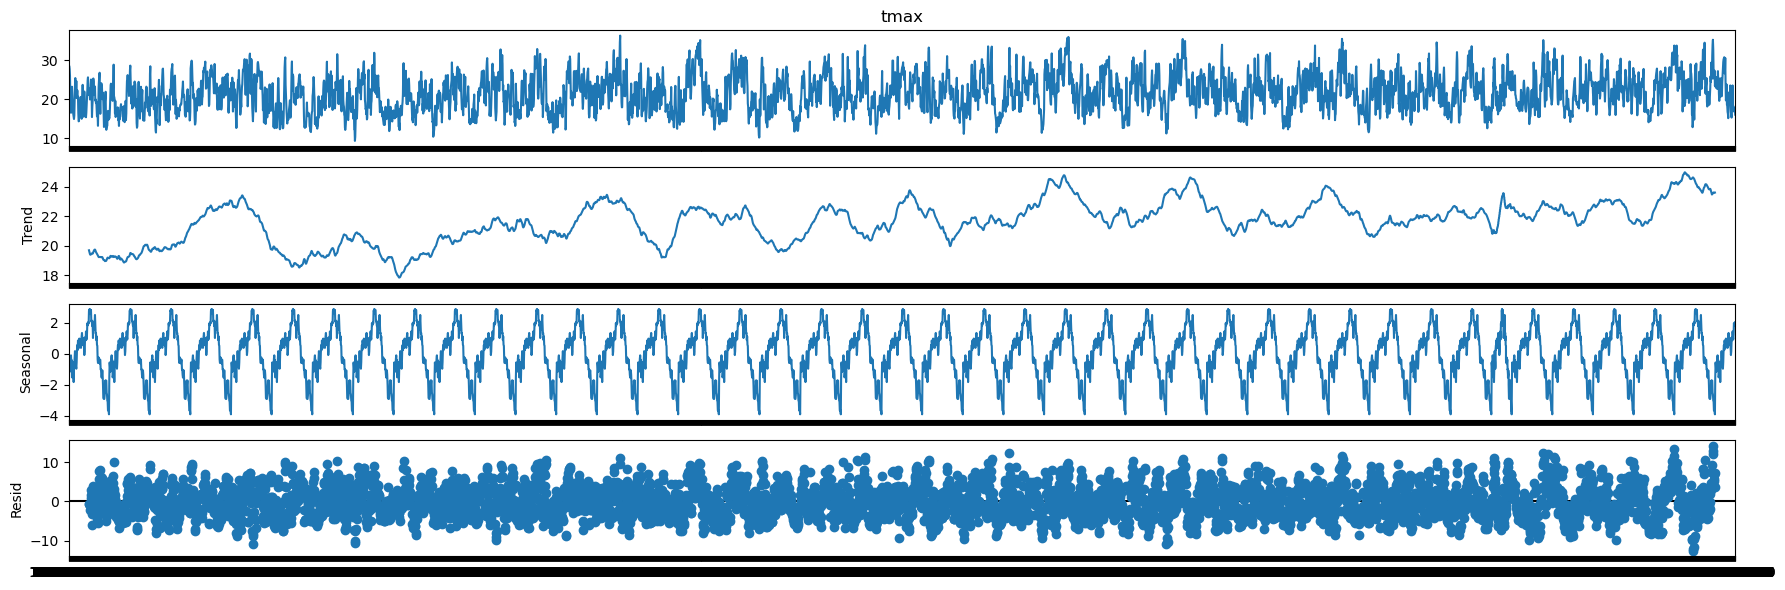

In [784]:
## temperature trend plot
trend = seasonal_decompose(df_heat['tmax'], period=122)
fig = trend.plot()
fig.set_size_inches((18, 6))
fig.tight_layout()
plt.savefig('decompose.png')

In [146]:
### MLP prediction

In [360]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
import warnings

In [743]:
## construct dataset with lags
from copy import deepcopy as dc

def shift_lag_data(df, n_lags):
    df = dc(df)
    
    for i in range(1, n_lags+1):
        df[f'tmax(t-{i})'] = df['tmax'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [748]:
## model and parameters tuning
data = df_heat.loc[:, 'tmax']
data = data.to_frame()
scaler = MinMaxScaler(feature_range=(-1, 1))

num_lags = [30, 60, 90, 120]
for num_lag in num_lags:
    shifted_data = shift_lag_data(data, num_lag)
    scaled_data = scaler.fit_transform(shifted_data)
    x, x_test, y, y_test = train_test_split(scaled_data[:,1:], scaled_data[:,0], test_size=0.1, train_size=0.9) ## split the data into training set, validation set and test set
    mlpr = MLPRegressor(max_iter=2000)
    param_list = {"hidden_layer_sizes": [(50,), (100,), (200,), (100, 50)],
                  "activation": ["identity", "logistic", "tanh", "relu"], 
                  "solver": ["sgd", "lbfgs", "adam"],
                  "alpha": [0.0005, 0.001, 0.005, 0.01]}

    gridCV = GridSearchCV(estimator=mlpr, param_grid=param_list, scoring='neg_mean_squared_error', cv=5, verbose=1)
    gridCV.fit(x, y)
    print('lag_num: {}, best_params: {}, best_score: {}'.format(num_lag, gridCV.best_params_, gridCV.best_score_))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
lag_num: 30, best_params: {'activation': 'identity', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}, best_score: -0.03802465537306543
Fitting 5 folds for each of 128 candidates, totalling 640 fits
lag_num: 60, best_params: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}, best_score: -0.0392861339648514
Fitting 5 folds for each of 128 candidates, totalling 640 fits
lag_num: 90, best_params: {'activation': 'logistic', 'alpha': 0.0005, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}, best_score: -0.03873380366382141
Fitting 5 folds for each of 128 candidates, totalling 640 fits


/var/folders/0r/06mcd6d15nl01q_rnr4zpvr40000gn/T/ipykernel_15847/3138116080.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tmax(t-{i})'] = df['tmax'].shift(i)
/var/folders/0r/06mcd6d15nl01q_rnr4zpvr40000gn/T/ipykernel_15847/3138116080.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tmax(t-{i})'] = df['tmax'].shift(i)
/var/folders/0r/06mcd6d15nl01q_rnr4zpvr40000gn/T/ipykernel_15847/3138116080.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [220]:
## best lag: 90
## best params: {'activation': 'identity', 'alpha': 0.01, 'hidden_layer_sizes': (200,), 'solver': 'lbfgs'}
## best score: 0.009472501251368809

In [749]:
## fit the data using the tuned params(random split)

shifted_data = shift_lag_data(data, 90)
scaled_data = scaler.fit_transform(shifted_data)
X, X_test, y, y_test = train_test_split(scaled_data[:,1:], scaled_data[:,0], test_size=0.1, train_size=0.9) ## split the data into training set, validation set and test set
mlpr = MLPRegressor(max_iter=2000, activation='identity', alpha=0.01, hidden_layer_sizes=(200,), solver='lbfgs')
mlpr.fit(X, y)

MLPRegressor(activation='identity', alpha=0.01, hidden_layer_sizes=(200,),
             max_iter=2000, solver='lbfgs')

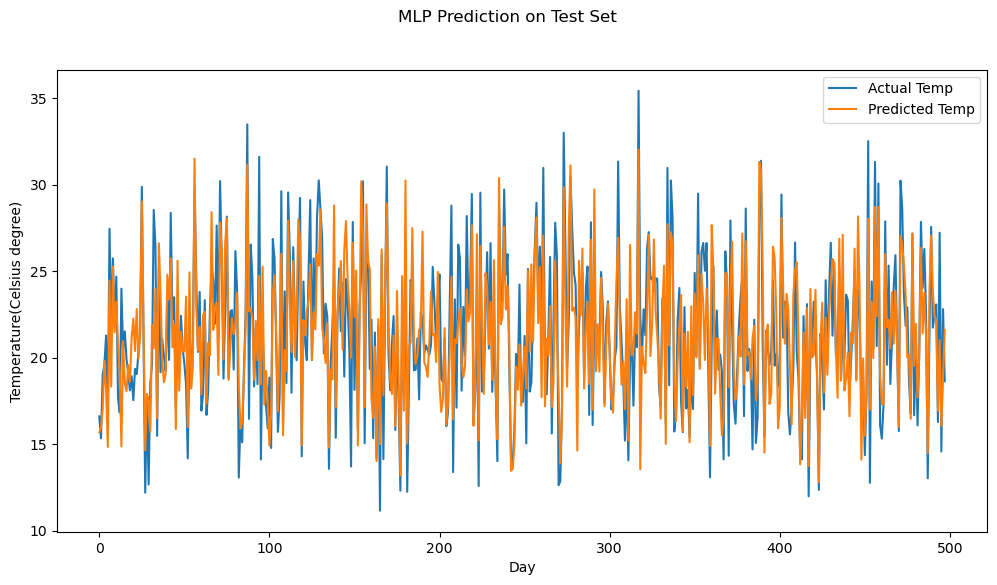

In [768]:
## mse on test set
test_pred = mlpr.predict(X_test)
dummies = np.zeros((X_test.shape[0], 91))
dummies[:, 0] = test_pred
dummies = scaler.inverse_transform(dummies)
test_pred = dc(dummies[:, 0])

dummies = np.zeros((X_test.shape[0], 91))
dummies[:, 0] = y_test
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])

plt.figure(figsize=(12, 6))
plt.plot(new_y_test, label='Actual Temp')
plt.plot(test_pred, label='Predicted Temp')
plt.xlabel('Day')
plt.ylabel('Temperature(Celsius degree)')
plt.suptitle('MLP Prediction on Test Set')
plt.legend()
plt.show()

In [769]:
mse(test_pred, new_y_test)

7.112541371198578

In [777]:
## Time-Series split
split_index = int(len(scaled_data) * 0.9)
X_train = scaled_data[:split_index, 1:]
X_test = scaled_data[split_index:, 1:]

y_train = scaled_data[:split_index, 0]
y_test = scaled_data[split_index:, 0]
mlpr.fit(X_train, y_train)

MLPRegressor(activation='identity', alpha=0.01, hidden_layer_sizes=(200,),
             max_iter=2000, solver='lbfgs')

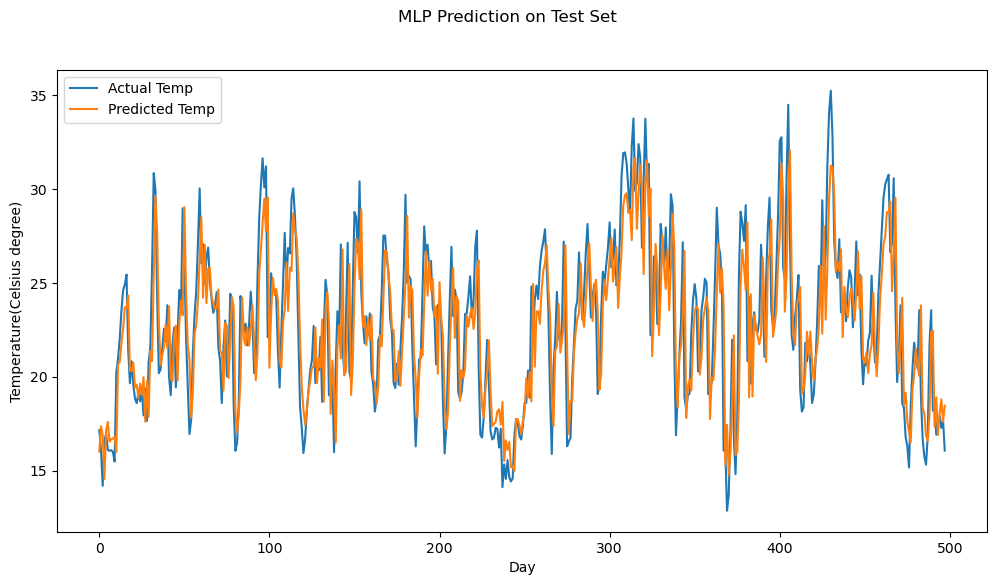

In [785]:
test_pred = mlpr.predict(X_test)
dummies = np.zeros((X_test.shape[0], 91))
dummies[:, 0] = test_pred
dummies = scaler.inverse_transform(dummies)
test_pred = dc(dummies[:, 0])

dummies = np.zeros((X_test.shape[0], 91))
dummies[:, 0] = y_test
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])

plt.figure(figsize=(12, 6))
plt.plot(new_y_test, label='Actual Temp')
plt.plot(test_pred, label='Predicted Temp')
plt.xlabel('Day')
plt.ylabel('Temperature(Celsius degree)')
plt.suptitle('MLP Prediction on Test Set')
plt.legend()
plt.savefig('MLP prediction')

In [779]:
mse(test_pred, new_y_test)

6.632697455449454

In [ ]:
## LSTM Time-Series Prediction

In [361]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [362]:
data = data.to_frame()
data['tmax'].plot(figsize=(12,6))

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [787]:
from copy import deepcopy as dc

def shift_lag_data(df, n_lags):
    df = dc(df)
    
    for i in range(1, n_lags+1):
        df[f'tmax(t-{i})'] = df['tmax'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

num_lag = 60
shifted_df = shift_lag_data(data, num_lag)
shifted_df.head()

,tmax,tmax(t-1),tmax(t-2),tmax(t-3),tmax(t-4),tmax(t-5),tmax(t-6),tmax(t-7),tmax(t-8),tmax(t-9),...,tmax(t-51),tmax(t-52),tmax(t-53),tmax(t-54),tmax(t-55),tmax(t-56),tmax(t-57),tmax(t-58),tmax(t-59),tmax(t-60)
date,,,,,,,,,,,,,,,,,,,,,
1979-07-31,22.814780,21.126525,25.612288,24.811237,22.210254,20.544966,18.294847,16.516831,15.406695,17.212136,...,20.028695,19.556864,16.548034,19.400593,21.213220,25.983559,27.726085,28.477542,28.522254,26.165169
1979-08-01,21.817034,22.814780,21.126525,25.612288,24.811237,22.210254,20.544966,18.294847,16.516831,15.406695,...,23.212119,20.028695,19.556864,16.548034,19.400593,21.213220,25.983559,27.726085,28.477542,28.522254
1979-08-02,21.625424,21.817034,22.814780,21.126525,25.612288,24.811237,22.210254,20.544966,18.294847,16.516831,...,21.641356,23.212119,20.028695,19.556864,16.548034,19.400593,21.213220,25.983559,27.726085,28.477542
1979-08-03,21.870780,21.625424,21.817034,22.814780,21.126525,25.612288,24.811237,22.210254,20.544966,18.294847,...,19.564288,21.641356,23.212119,20.028695,19.556864,16.548034,19.400593,21.213220,25.983559,27.726085
1979-08-04,19.951542,21.870780,21.625424,21.817034,22.814780,21.126525,25.612288,24.811237,22.210254,20.544966,...,16.723898,19.564288,21.641356,23.212119,20.028695,19.556864,16.548034,19.400593,21.213220,25.983559


In [788]:
shifted_df_as_np = shifted_df.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.00094462, -0.12631585,  0.20680079, ...,  0.41957705,
         0.42289739,  0.24785823],
       [-0.07503809, -0.00094462, -0.12631585, ...,  0.36377316,
         0.41957705,  0.42289739],
       [-0.08926723, -0.07503809, -0.00094462, ...,  0.23437171,
         0.36377316,  0.41957705],
       ...,
       [-0.41268471, -0.36644226, -0.38446558, ...,  0.09730683,
         0.04492281,  0.3338578 ],
       [-0.38221768, -0.41268471, -0.36644226, ...,  0.10710123,
         0.09730683,  0.04492281],
       [-0.5022393 , -0.38221768, -0.41268471, ...,  0.0094783 ,
         0.10710123,  0.09730683]])

In [789]:
X = shifted_df_as_np[:, 1:]
X = dc(np.flip(X, axis=1))
y = shifted_df_as_np[:, 0]
X.shape, y.shape

((5003, 60), (5003,))

In [790]:
split_index = int(len(X) * 0.9)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, num_lag, 1))
X_test = X_test.reshape((-1, num_lag, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4502, 60, 1]),
 torch.Size([501, 60, 1]),
 torch.Size([4502, 1]),
 torch.Size([501, 1]))

In [791]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [792]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [793]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 60, 1]) torch.Size([64, 1])


In [794]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        
        # Propagate input through LSTM
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        
        return out
    
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [795]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch+1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_index % 100 == 99: # print every 100 batches
            avg_loss_across_batches = running_loss/100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            
            running_loss = 0.0
    print()

In [796]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            
    avg_loss_across_batches = running_loss/len(test_loader)
    
    print('Val Loss: {0: .3f}'.format(avg_loss_across_batches))
    print()

In [797]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    

Epoch: 1

Val Loss:  0.089

Epoch: 2

Val Loss:  0.065

Epoch: 3

Val Loss:  0.053

Epoch: 4

Val Loss:  0.048

Epoch: 5

Val Loss:  0.045

Epoch: 6

Val Loss:  0.042

Epoch: 7

Val Loss:  0.041

Epoch: 8

Val Loss:  0.038

Epoch: 9

Val Loss:  0.037

Epoch: 10

Val Loss:  0.036

Epoch: 11

Val Loss:  0.036

Epoch: 12

Val Loss:  0.035

Epoch: 13

Val Loss:  0.035

Epoch: 14

Val Loss:  0.035

Epoch: 15

Val Loss:  0.035

Epoch: 16

Val Loss:  0.035

Epoch: 17

Val Loss:  0.035

Epoch: 18

Val Loss:  0.035

Epoch: 19

Val Loss:  0.035

Epoch: 20

Val Loss:  0.035

Epoch: 21

Val Loss:  0.035

Epoch: 22

Val Loss:  0.035

Epoch: 23

Val Loss:  0.035

Epoch: 24

Val Loss:  0.035

Epoch: 25

Val Loss:  0.036

Epoch: 26

Val Loss:  0.035

Epoch: 27

Val Loss:  0.035

Epoch: 28

Val Loss:  0.036

Epoch: 29

Val Loss:  0.035

Epoch: 30

Val Loss:  0.035

Epoch: 31

Val Loss:  0.035

Epoch: 32

Val Loss:  0.035

Epoch: 33

Val Loss:  0.035

Epoch: 34

Val Loss:  0.035

Epoch: 35

Val Loss:  0

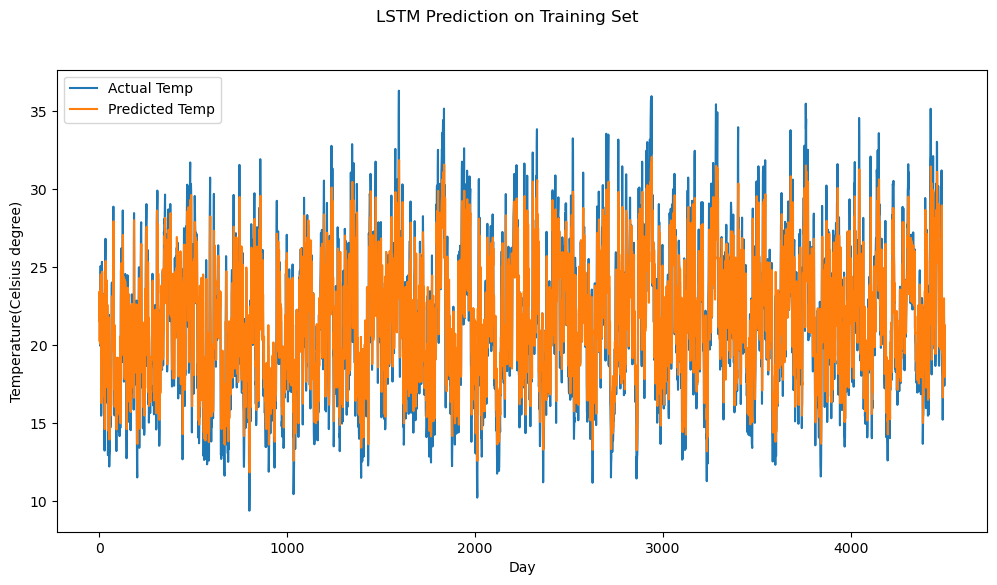

In [799]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

    
train_pred = predicted.flatten()
dummies = np.zeros((X_train.shape[0], num_lag+1))
dummies[:, 0] = train_pred
dummies = scaler.inverse_transform(dummies)
train_pred = dc(dummies[:, 0])

dummies = np.zeros((X_train.shape[0], num_lag+1))
dummies[:, 0] = y_train.numpy().flatten()
dummies = scaler.inverse_transform(dummies)
new_y_train = dc(dummies[:, 0])


plt.figure(figsize=(12, 6))
plt.plot(new_y_train, label='Actual Temp')
plt.plot(train_pred, label='Predicted Temp')
plt.xlabel('Day')
plt.ylabel('Temperature(Celsius degree)')
plt.suptitle('LSTM Prediction on Training Set')
plt.legend()
plt.show()

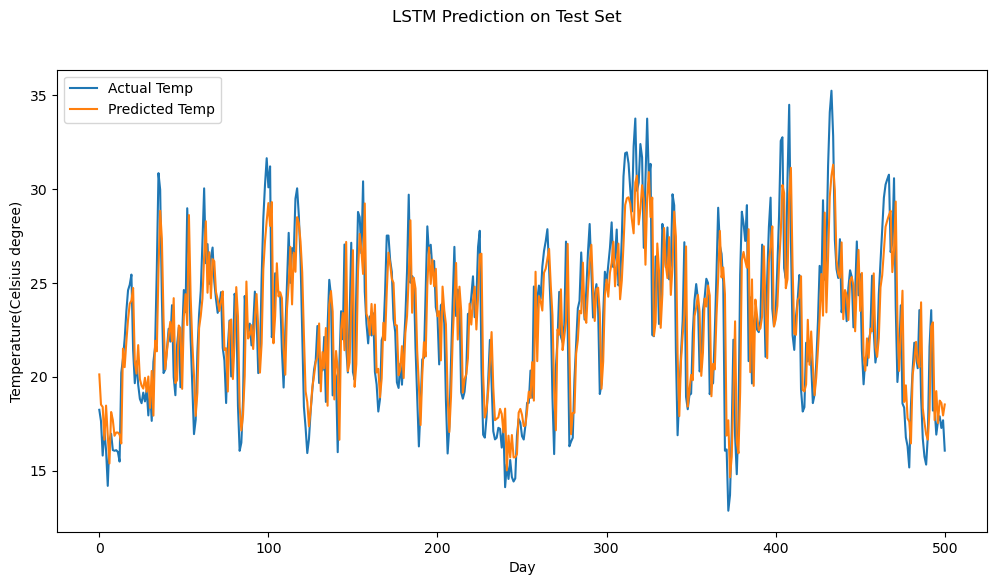

In [800]:
test_pred = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], num_lag+1))
dummies[:, 0] = test_pred
dummies = scaler.inverse_transform(dummies)
test_pred = dc(dummies[:, 0])

dummies = np.zeros((X_test.shape[0], num_lag+1))
dummies[:, 0] = y_test.numpy().flatten()
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])

plt.figure(figsize=(12, 6))
plt.plot(new_y_test, label='Actual Temp')
plt.plot(test_pred, label='Predicted Temp')
plt.xlabel('Day')
plt.ylabel('Temperature(Celsius degree)')
plt.suptitle('LSTM Prediction on Test Set')
plt.legend()
plt.savefig('LSTM Prediction.png')

In [652]:
test_mse = {}

In [697]:
test_mse[120] = mse(test_pred, new_y_test)

In [698]:
test_mse

{60: 6.340148550455773,
 30: 6.352927681055427,
 90: 6.359420261376765,
 120: 6.486339494281615}

In [801]:
mse(test_pred, new_y_test)

6.345464518150901